<a href="https://colab.research.google.com/github/tarang1998/ML-AI-DL/blob/main/deep-learning/Back_propogation_in_Neural_Networks_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import math

In [73]:
class Value:

  def __init__(self,data, _children=(), _op="" , label =""):
    self.data = data
    self.grad = 0
    self._prev = set(_children)
    self.label = label
    self._op = _op
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out =  Value(self.data + other.data,(self,other),"+")
    def _backward():
      self.grad += 1 * out.grad
      other.grad += 1 * out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out =  Value(self.data * other.data,  (self,other),"*")
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')
    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward
    return out

  def __truediv__(self, other):
    return self * other**-1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    def backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = backward
    return out

  def backward(self):
    topo = []
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1
    for node in reversed(topo):
      node._backward()



In [49]:
from graphviz import Digraph


In [50]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [51]:
# Forward propogation of a mathematical expression

a = Value(2, label='a')
b = Value(-3, label='b')
c = Value(10,label='c')

d = a * b
d.label = "d"

e = c + d
e.label = "e"

f = Value(-2, label="f")

L = e * f
L.label = "L"



In [52]:
# Manual Backpropogation of the expression

# dL/dL = 1
L.grad = 1

# L = e * f
# dL/df = e
f.grad = e.data

# L = e * f
# dL/de = f
e.grad = f.data

# e = c + d
# de/dc = 1
# dL/dc = dL/de * de/dc
c.grad = e.grad * 1

# e = c + d
# de/dd = 1
# dL/dd = dL/de * de/dd
d.grad = e.grad * 1

# d = a * b
# dd/da = b
# dL/da = dL/dd * dd/da
a.grad = d.grad * b.data

# d = a * b
# dd/db = a
# dL/db = dL/dd * dd/db
b.grad = d.grad * a.data


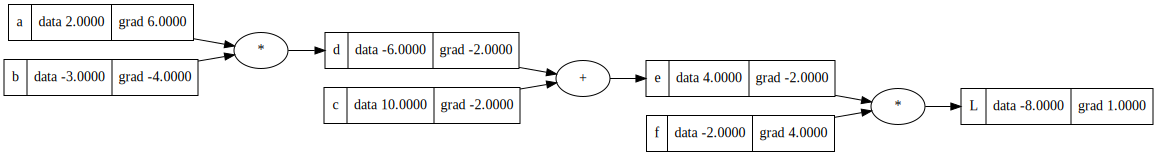

In [53]:
draw_dot(L)

In [59]:
# Forward propogation of a neural network unit

# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

out = n.tanh(); out.label = 'out'



In [60]:
# Manual back propogation of the NN unit

# dout/dout = 1
out.grad = 1

# out = tanh(n)
# dtanh(n)/dn = 1 - tanh(n)^2
# dout/dn = dtanh(n)/dn = 1 - out^2
n.grad = 1 - (out.data ** 2)

# n = w1x1 + w2x2 + b
# dn/db = 1
# dout/dn = 1
# dout/db = dout/dn * dn/db = 1 - out^2
b.grad = n.grad * 1

# dout/d(w1x1+w2x2) = dout/dn * dout/dn = 1 - out^2
x1w1x2w2.grad = n.grad * 1

# dout/dx1w1 = dout/d(w1x1+w2x2) * d(w1x1+w2x2)/dx1w1
# dout/dx2w2 = dout/d(w1x1+w2x2) * d(w1x1+w2x2)/dx2w2
x1w1.grad = x1w1x2w2.grad * 1
x2w2.grad = x1w1x2w2.grad * 1

# dout/x2 = dout/dx2w2 * dx2w2/dx2
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

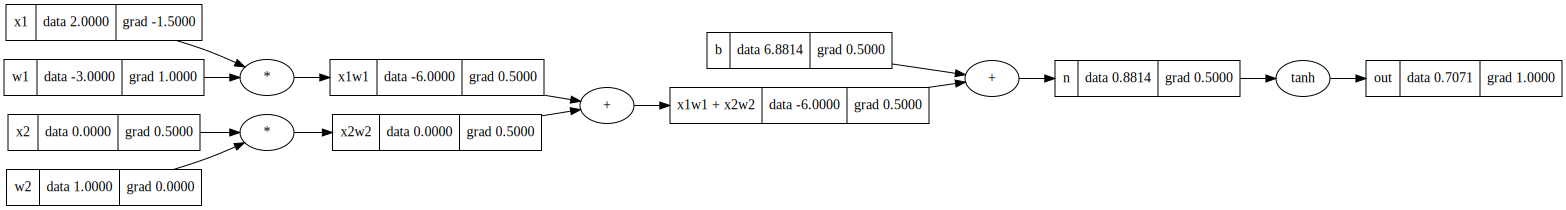

In [61]:
draw_dot(out)


In [62]:
# Forward propogation of a neural network unit

# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

out = n.tanh(); out.label = 'out'

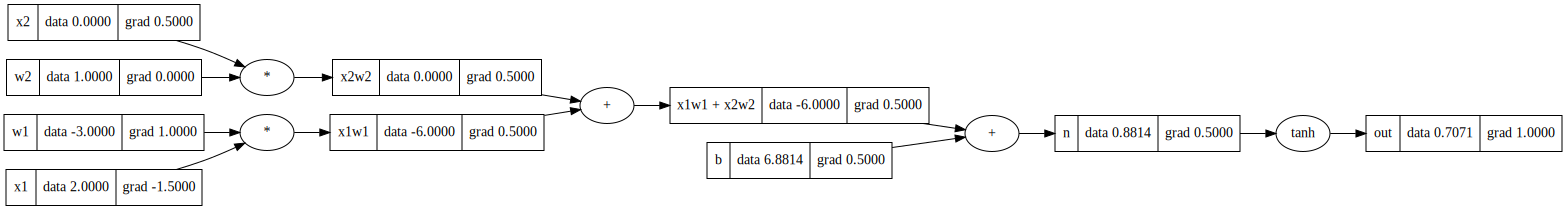

In [63]:
# Backward propogation of the NN unit calling each objects backward function
# Which assigns a grad value to its children

out.grad = 1
out._backward()

n._backward()

x1w1x2w2._backward()
b._backward()

x1w1._backward()
x2w2._backward()

x2._backward()
w2._backward()

x1._backward()
w1._backward()

draw_dot(out)



In [64]:
# Forward propogation of a neural network

# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

out = n.tanh(); out.label = 'out'

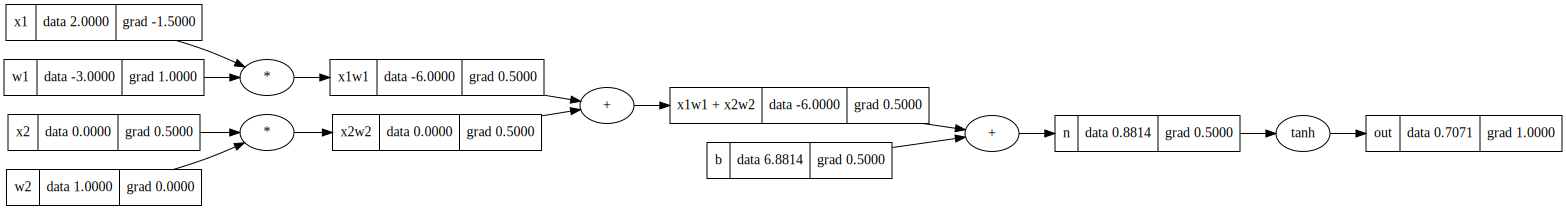

In [65]:
# Back prop using Topological sort

out.grad = 1

topo = []
visited = set()

def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)

build_topo(out)


for node in reversed(topo):
  node._backward()

draw_dot(out)

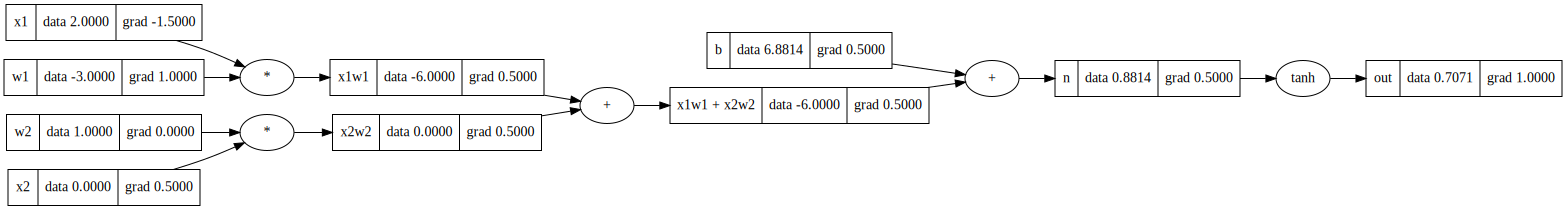

In [69]:
# Forward and Back propogation of a neural network

# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

out = n.tanh(); out.label = 'out'

out.backward() # Uses topo sort internally

draw_dot(out)

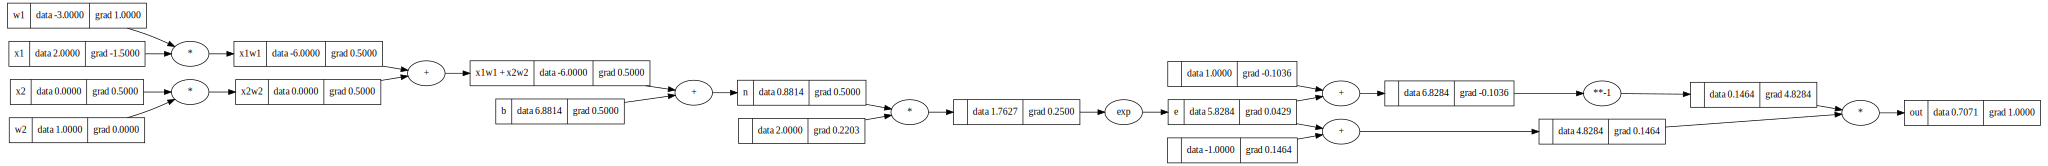

In [74]:
# Forward and Back propogation of a neural network

# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
e.label = 'e'
out = (e - 1) / (e + 1)
out.label = 'out'

out.backward() # Uses topo sort internally

draw_dot(out)

In [75]:
import torch

x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True

x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True

w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737
